In [2]:
import numpy as np
import matplotlib.pyplot as plt


In [3]:
class Environment:
    def __init__(self, env_type="choice") -> None:
        self.state = 0
        self.terminated = False
        self.env_type = env_type

    def reset(self):
        self.state = 0
        self.terminated=True

    def new_ep(self):
        self.terminated=False
        
    def get_state(self):
        return self.state

    def get_reward(self, action):
        if self.env_type=="choice":
            # action=0->L, a=1->R, a=2->C
            if self.state == 0:
                rewards = [1, 2, -1]
                reward = rewards[action]
            elif self.state == 1:
                rewards = [8,-8]
                reward = rewards[action]
            elif self.state == 2:
                rewards = [0,4]
                reward = rewards[action]
        elif self.env_type=="maze":
            if self.state == 0:
                reward = 0
            elif self.state == 1:
                rewards = [4,0]
                reward = rewards[action]
            elif self.state == 2:
                rewards = [2,3]
                reward = rewards[action]
        return reward
    
    def take_step(self,  action):
        self.terminated = False
        reward = self.get_reward(action)
        if self.env_type=="choice":
            if self.state == 0:
                if action < 2:
                    # there is no further state
                    self.reset()
                else:
                    #random transition to left or right if C is chosen
                    self.state = np.random.randint(1,3)
            else:
                # there is no further state
                self.reset()
        elif self.env_type=="maze":
            if self.state == 0:
                self.state = self.state + 1 + action
            else:
                # there is no further state
                self.reset()
        return reward


In [4]:
class Agent:
    def __init__(self, env, epsilon_a=0.075, policy_type="random", epsilon_c=0.2, decay=0, beta=1, env_type="choice") -> None:
        self.env_type = env_type
        if self.env_type == "choice":
            self.vs = np.zeros(3)
            self.ms = [[0,0,0],[0,0],[0,0]]
            self.policy = [[1/3,1/3,1/3],[0.5,0.5],[0.5,0.5]]
        elif self.env_type == "maze":
            self.vs = np.zeros(3)
            self.ms = [[0,0],[0,0],[0,0]]
            self.policy = [[0.5,0.5],[0.5,0.5],[0.5,0.5]]
        self.policy_type = policy_type
        self.env = env
        self.epsilon_a = epsilon_a
        self.epsilon_c = epsilon_c
        self.decay = decay
        self.beta = beta

    def reset(self):
        #reset at start of new epoch
        if self.env_type == "choice":
            self.vs = np.zeros(3)
            self.ms = [[0,0,0],[0,0],[0,0]]
            self.policy = [[1/3,1/3,1/3],[0.5,0.5],[0.5,0.5]]
        elif self.env_type == "maze":
            self.vs = np.zeros(3)
            self.ms = [[0,0],[0,0],[0,0]]
            self.policy = [[0.5,0.5],[0.5,0.5],[0.5,0.5]]

    def critic(self):
        return self.vs

    def actor(self):
        state = self.env.get_state()               
        if self.env_type == "choice":
            if state == 0:
                action = np.random.choice(np.arange(3), p=self.policy[state])
            else:
                action = np.random.choice(np.arange(2), p=self.policy[state])
        elif self.env_type == "maze":
            action = np.random.choice(np.arange(2), p=self.policy[state])
        return action
    
    def update_policy(self, state, reward, new_state,action):
        if self.env_type == "choice":
            if action < 2:
                delta = reward - self.vs[state]
            else:
                delta = reward + self.vs[new_state] - self.vs[state]
        elif self.env_type == "maze":
            if state == 0:
                delta = reward + self.vs[new_state] - self.vs[state]
            else:
                delta = reward - self.vs[state]
        for a in range(len(self.ms[state])):  
            self.ms[state][a] = (1-self.decay)*self.ms[state][a] + self.epsilon_a*self.delta_func(action,a)*delta
            self.policy[state] = self.softmax(self.ms[state])
        return self.policy

    def update_weights(self, reward, state, new_state):
        if new_state != 0:
            delta = reward + self.vs[new_state] - self.vs[state]
        else:
            delta = reward - self.vs[state]

        self.vs[state] += self.epsilon_c * delta

        return self.vs

    def softmax(self,x):
        for x_i in x:
            x_i = self.beta * x_i
        return(np.exp(x)/np.exp(x).sum())

    def delta_func(self,a,b):
        return a == b



In [16]:
# policy evaluation
episodes = 1000
epochs = 1000
epsilon = 0.1

env = Environment()
agent = Agent(env=env, epsilon_a = epsilon, policy_type="actor_critic")
v_over_epochs_pe = np.zeros((epochs,episodes, 3))
for epoch in range(epochs):
    agent.reset()

    for episode in range(episodes):
        for step in range(2):
            if env.terminated == False:
                state = env.get_state()
                vs = agent.critic()
                action = agent.actor()
                reward = env.take_step(action)
                new_state = env.get_state()
                agent.update_weights(reward, state, new_state)

        v_over_epochs_pe[epoch,episode] = vs
        env.new_ep()



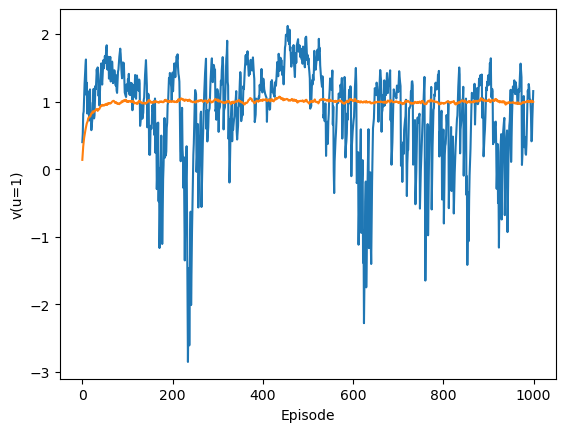

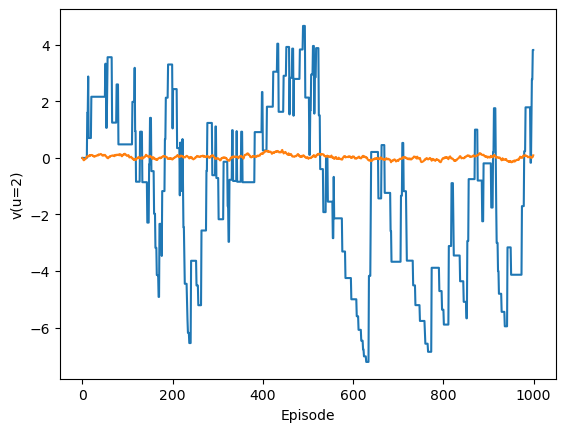

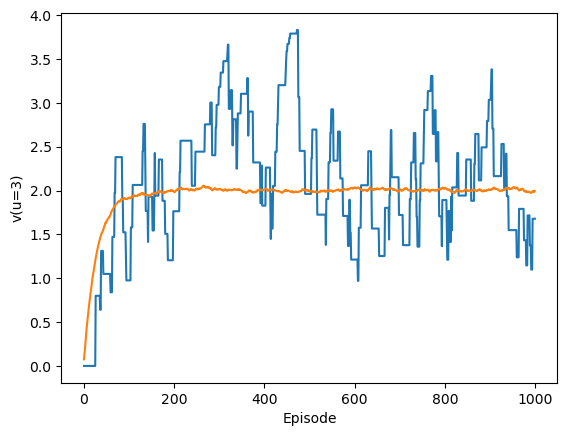

In [39]:
# plot policy evaluation
means_per_epoch_1_pe = np.mean(v_over_epochs_pe[:,:,0], axis=0)
plt.plot(range(epochs), v_over_epochs_pe[0,:,0])
plt.plot(range(epochs), means_per_epoch_1_pe)
plt.xlabel("Episode")
plt.ylabel("v(u=1)")
plt.show()
means_per_epoch_2_pe = np.mean(v_over_epochs_pe[:,:,1], axis=0)
plt.plot(range(epochs), v_over_epochs_pe[0,:,1])
plt.plot(range(epochs), means_per_epoch_2_pe)
plt.xlabel("Episode")
plt.ylabel("v(u=2)")
plt.show()

means_per_epoch_3_pe = np.mean(v_over_epochs_pe[:,:,2], axis=0)
plt.plot(range(epochs), v_over_epochs_pe[0,:,2])
plt.plot(range(epochs), means_per_epoch_3_pe)
plt.xlabel("Episode")
plt.ylabel("v(u=3)")
plt.show()





In [50]:
#actor critic learning
episodes = 1000
epochs = 1000
env = Environment()
agent = Agent(env=env, policy_type="actor_critic")
v_over_epochs = np.zeros((epochs,episodes, 3))
policy_over_epochs = np.zeros((epochs,episodes, 7))

for epoch in range(epochs):
    agent.reset()

    for episode in range(episodes):
        for step in range(2):
            if env.terminated == False:
                state = env.get_state()
                vs = agent.critic()
                action = agent.actor()
                reward = env.take_step(action)
                new_state = env.get_state()
                policy = agent.update_policy(state, reward, new_state,action)
                agent.update_weights(reward, state, new_state)

        v_over_epochs[epoch,episode] = vs
        pol = np.concatenate((policy[0],policy[1],policy[2]))
        policy_over_epochs[epoch,episode] = pol
        env.new_ep()



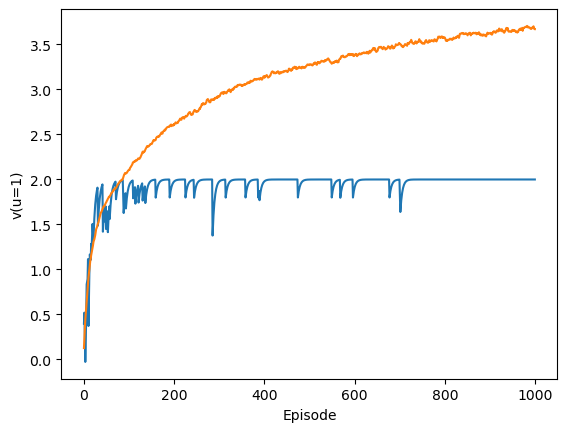

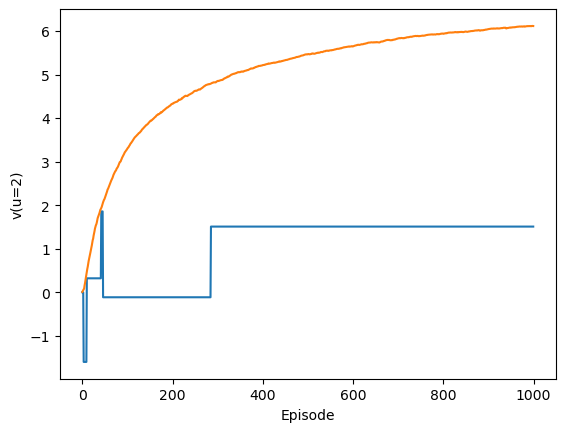

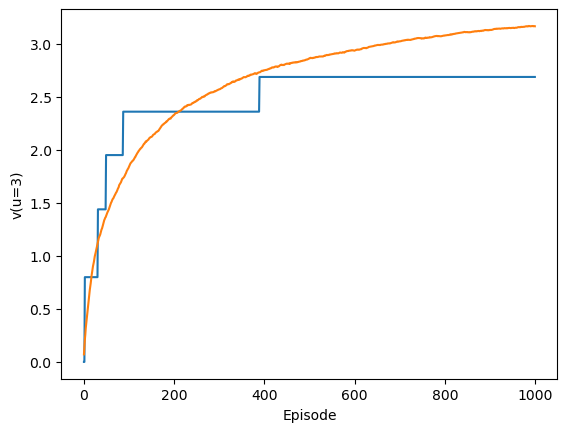

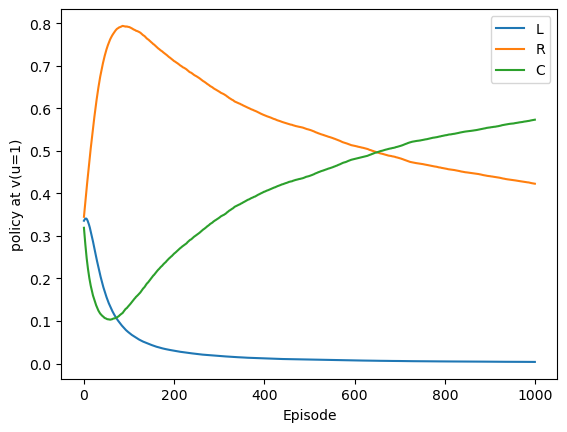

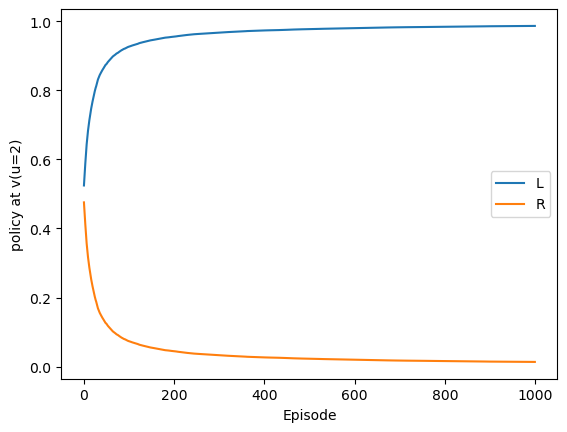

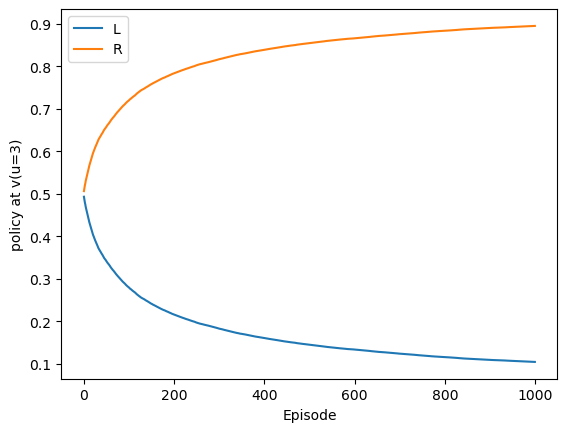

In [51]:
# plot actor critic results

means_per_epoch_1 = np.mean(v_over_epochs[:,:,0], axis=0)
plt.plot(range(epochs), v_over_epochs[0,:,0])
plt.plot(range(epochs), means_per_epoch_1)
plt.xlabel("Episode")
plt.ylabel("v(u=1)")
plt.show()

means_per_epoch_2 = np.mean(v_over_epochs[:,:,1], axis=0)
plt.plot(range(epochs), v_over_epochs[0,:,1])
plt.plot(range(epochs), means_per_epoch_2)
plt.xlabel("Episode")
plt.ylabel("v(u=2)")
plt.show()

means_per_epoch_3 = np.mean(v_over_epochs[:,:,2], axis=0)
plt.plot(range(epochs), v_over_epochs[0,:,2])
plt.plot(range(epochs), means_per_epoch_3)
plt.xlabel("Episode")
plt.ylabel("v(u=3)")
plt.show()

mean_policy_over_epochs_1 = np.mean(policy_over_epochs[:,:,:], axis=0)
plt.plot(range(epochs), mean_policy_over_epochs_1[:,0], label="L")
plt.plot(range(epochs), mean_policy_over_epochs_1[:,1], label="R")
plt.plot(range(epochs), mean_policy_over_epochs_1[:,2], label="C")
plt.xlabel("Episode")
plt.ylabel("policy at v(u=1)")
plt.legend()
plt.show()


plt.plot(range(epochs), mean_policy_over_epochs_1[:,3], label="L")
plt.plot(range(epochs), mean_policy_over_epochs_1[:,4], label="R")
plt.xlabel("Episode")
plt.ylabel("policy at v(u=2)")
plt.legend()
plt.show()

plt.plot(range(epochs), mean_policy_over_epochs_1[:,5], label="L")
plt.plot(range(epochs), mean_policy_over_epochs_1[:,6], label="R")
plt.xlabel("Episode")
plt.ylabel("policy at v(u=3)")
plt.legend()
plt.show()

In [49]:
#test different parameters
episodes = 1000
epochs = 300
v_over_epochs_test = np.zeros((11,epochs,episodes, 3))
policy_over_epochs_test = np.zeros((11,epochs,episodes, 7))
parameters = np.linspace(0.5,0.5,1)
for p in range(parameters.shape[0]):

    env = Environment()
    agent = Agent(env=env, epsilon_a=0.025, policy_type="random", epsilon_c=parameters[p], decay=0, beta=0.6)
    
    for epoch in range(epochs):
        agent.reset()

        for episode in range(episodes):
            for step in range(2):
                if env.terminated == False:
                    state = env.get_state()
                    vs = agent.critic()
                    action = agent.actor()
                    reward = env.take_step(action)
                    new_state = env.get_state()
                    policy = agent.update_policy(state, reward, new_state,action)
                    agent.update_weights(reward, state, new_state)

            v_over_epochs_test[p,epoch,episode] = vs
            
            pol = np.concatenate((policy[0],policy[1],policy[2]))
            policy_over_epochs_test[p,epoch,episode] = pol
            env.new_ep()



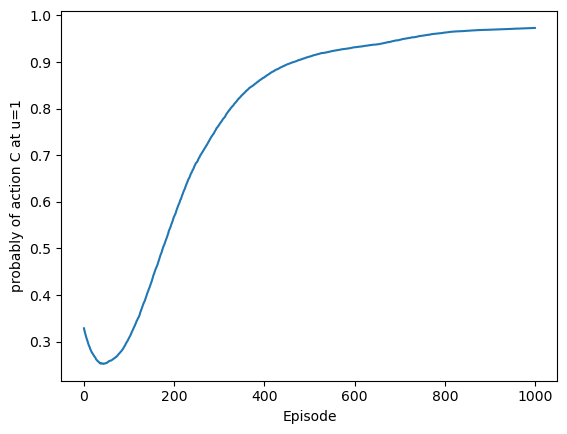

In [52]:
prob_C = np.mean(policy_over_epochs_test[:,:,:,2], axis=1)
for p in range(parameters.shape[0])[:11]:
    label = np.round(parameters[p],4)
    plt.plot(range(episodes), prob_C[p,:], label=label)

plt.xlabel("Episode")
plt.ylabel("probably of action C at u=1")
# plt.legend()
plt.show()

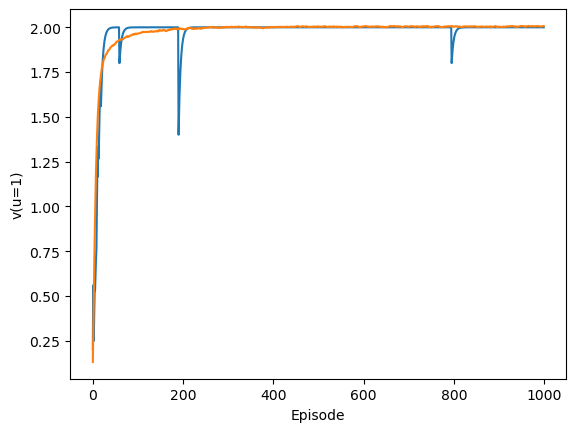

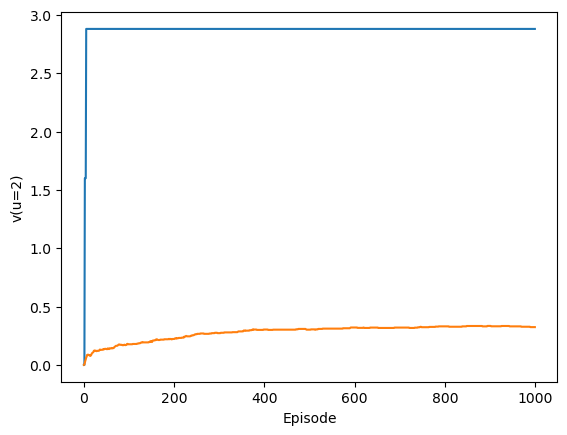

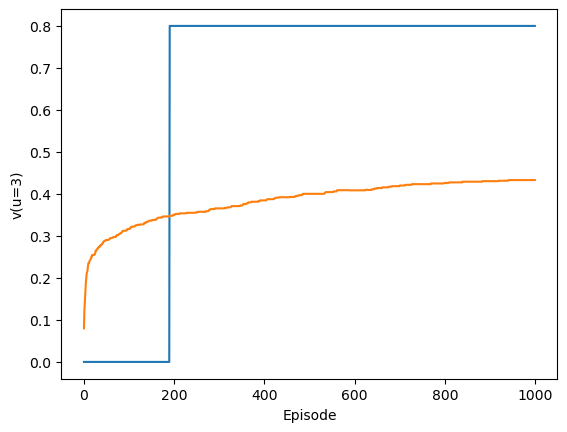

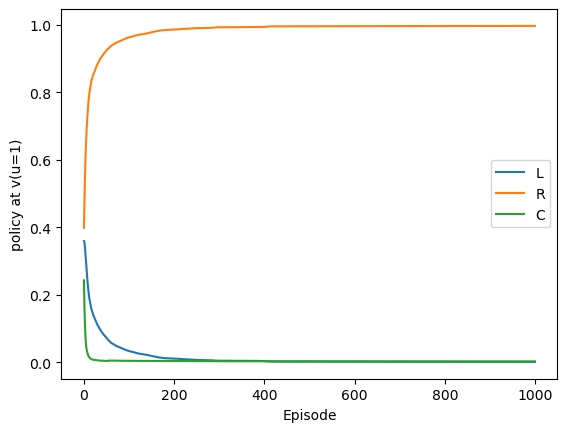

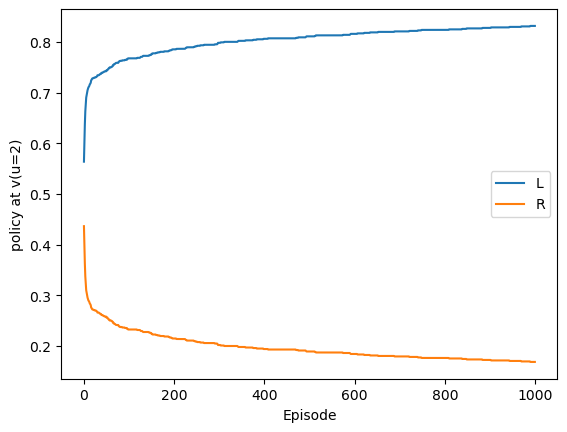

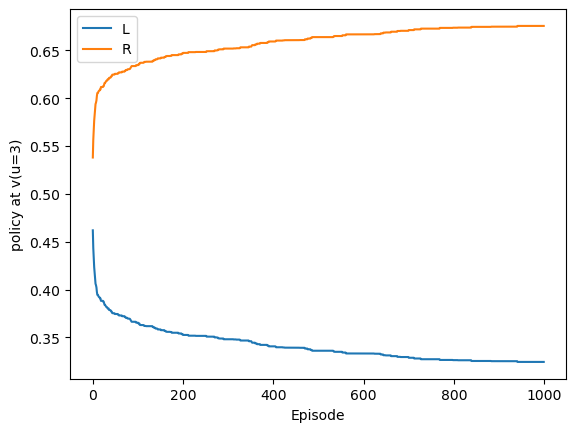

In [9]:
means_per_epoch_test = np.mean(v_over_epochs_test[:,:,:], axis=0)
plt.plot(range(episodes), v_over_epochs_test[0,:,0])
plt.plot(range(episodes), means_per_epoch_test[:,0])
plt.xlabel("Episode")
plt.ylabel("v(u=1)")
plt.show()

plt.plot(range(episodes), v_over_epochs_test[0,:,1])
plt.plot(range(episodes), means_per_epoch_test[:,1])
plt.xlabel("Episode")
plt.ylabel("v(u=2)")
plt.show()


plt.plot(range(episodes), v_over_epochs_test[0,:,2])
plt.plot(range(episodes), means_per_epoch_test[:,2])
plt.xlabel("Episode")
plt.ylabel("v(u=3)")
plt.show()

mean_policy_over_epochs_test = np.mean(policy_over_epochs_test[:,:,:], axis=0)
plt.plot(range(episodes), mean_policy_over_epochs_test[:,0], label="L")
plt.plot(range(episodes), mean_policy_over_epochs_test[:,1], label="R")
plt.plot(range(episodes), mean_policy_over_epochs_test[:,2], label="C")
plt.xlabel("Episode")
plt.ylabel("policy at v(u=1)")
plt.legend()
plt.show()


plt.plot(range(episodes), mean_policy_over_epochs_test[:,3], label="L")
plt.plot(range(episodes), mean_policy_over_epochs_test[:,4], label="R")
plt.xlabel("Episode")
plt.ylabel("policy at v(u=2)")
plt.legend()
plt.show()

plt.plot(range(episodes), mean_policy_over_epochs_test[:,5], label="L")
plt.plot(range(episodes), mean_policy_over_epochs_test[:,6], label="R")
plt.xlabel("Episode")
plt.ylabel("policy at v(u=3)")
plt.legend()
plt.show()

In [48]:
#maze task: actor critic learning 
episodes = 1000
epochs = 1000
env = Environment(env_type="maze")
agent = Agent(env=env, policy_type="actor_critic", env_type="maze")
v_over_epochs_maze = np.zeros((epochs,episodes, 3))
policy_over_epochs_maze = np.zeros((epochs,episodes, 6))

for epoch in range(epochs):
    agent.reset()

    for episode in range(episodes):
        for step in range(2):
            if env.terminated == False:
                state = env.get_state()
                vs = agent.critic()
                action = agent.actor()
                reward = env.take_step(action)
                new_state = env.get_state()
                policy = agent.update_policy(state, reward, new_state,action)
                agent.update_weights(reward, state, new_state)

        v_over_epochs_maze[epoch,episode] = vs
        pol = np.concatenate((policy[0],policy[1],policy[2]))
        policy_over_epochs_maze[epoch,episode] = pol
        env.new_ep()


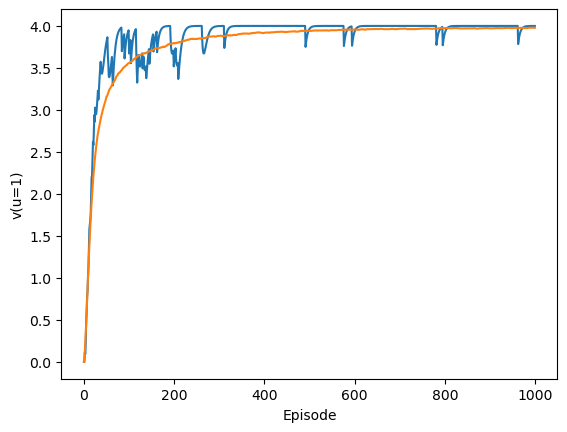

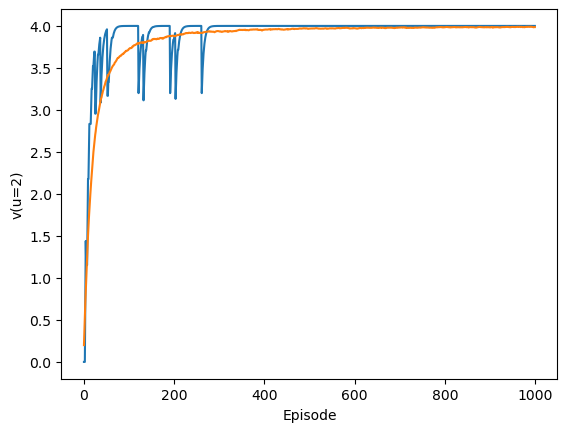

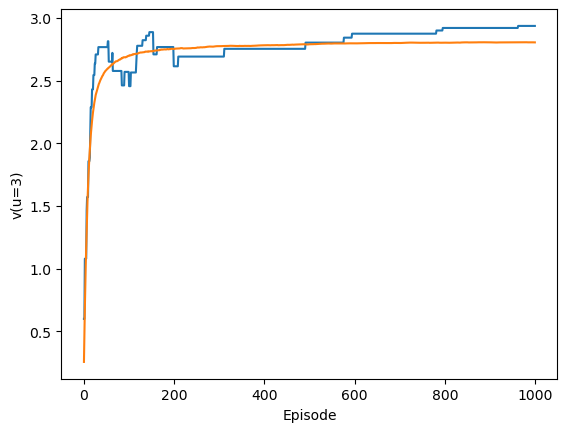

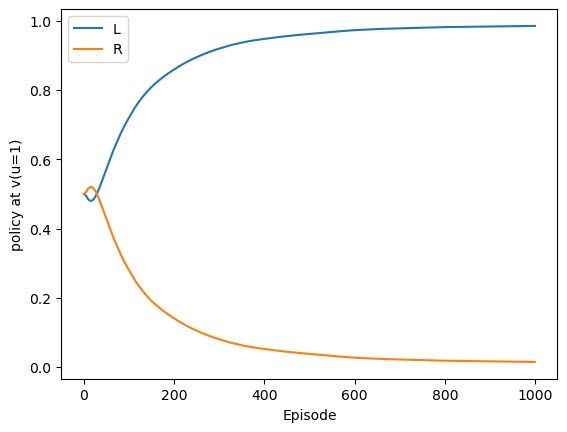

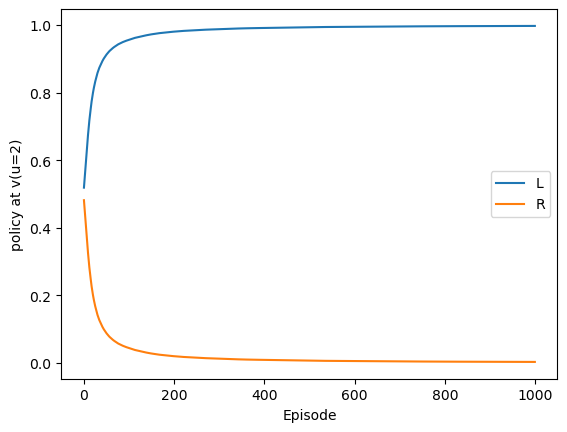

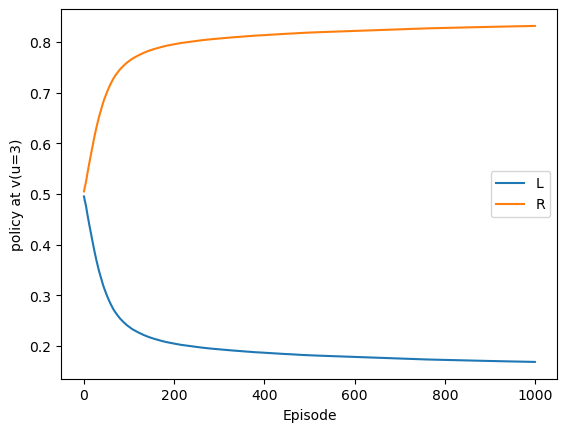

In [49]:
means_per_epoch_test = np.mean(v_over_epochs_maze[:,:,:], axis=0)
plt.plot(range(epochs), v_over_epochs_maze[0,:,0])
plt.plot(range(epochs), means_per_epoch_test[:,0])
plt.xlabel("Episode")
plt.ylabel("v(u=1)")
plt.show()

plt.plot(range(epochs), v_over_epochs_maze[0,:,1])
plt.plot(range(epochs), means_per_epoch_test[:,1])
plt.xlabel("Episode")
plt.ylabel("v(u=2)")
plt.show()

plt.plot(range(epochs), v_over_epochs_maze[0,:,2])
plt.plot(range(epochs), means_per_epoch_test[:,2])
plt.xlabel("Episode")
plt.ylabel("v(u=3)")
plt.show()

mean_policy_over_epochs_maze = np.mean(policy_over_epochs_maze[:,:,:], axis=0)
plt.plot(range(epochs), mean_policy_over_epochs_maze[:,0], label="L")
plt.plot(range(epochs), mean_policy_over_epochs_maze[:,1], label="R")
plt.xlabel("Episode")
plt.ylabel("policy at v(u=1)")
plt.legend()
plt.show()


plt.plot(range(epochs), mean_policy_over_epochs_maze[:,2], label="L")
plt.plot(range(epochs), mean_policy_over_epochs_maze[:,3], label="R")
plt.xlabel("Episode")
plt.ylabel("policy at v(u=2)")
plt.legend()
plt.show()

plt.plot(range(epochs), mean_policy_over_epochs_maze[:,4], label="L")
plt.plot(range(epochs), mean_policy_over_epochs_maze[:,5], label="R")
plt.xlabel("Episode")
plt.ylabel("policy at v(u=3)")
plt.legend()
plt.show()